In [90]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import src.segnet_model as segnet_model
import src.segtools as segtools
from keras import optimizers
from glob import glob
import os
import json
from sklearn.metrics import confusion_matrix
import itertools
from PIL import Image
from ipywidgets import interact, widgets
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
model_json = './fit_models/beta_v1/seg_net.json' 
model_weight = './fit_models/beta_v1/seg_net.h5' 
model = segnet_model.import_model(model_json, model_weight)
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', \
                     optimizer=opt, metrics=['categorical_accuracy'])
print('Model compiled!')

Model compiled!


In [4]:
# data type is wrong in validation
# get validation data to check things out
val_batch = len(glob('./images/val/a/*.png'))
val_generator = segtools.data_generator('/contents/images/val', batch_size=val_batch)
x_val, y_val = next(val_generator)
n_classes = 2
y_val, _ = segtools.post_process_y(y_val, n_classes)

In [26]:
pr = model.predict(x_val)
y_hat, y_pr = segtools.post_process_y(pr, n_classes)

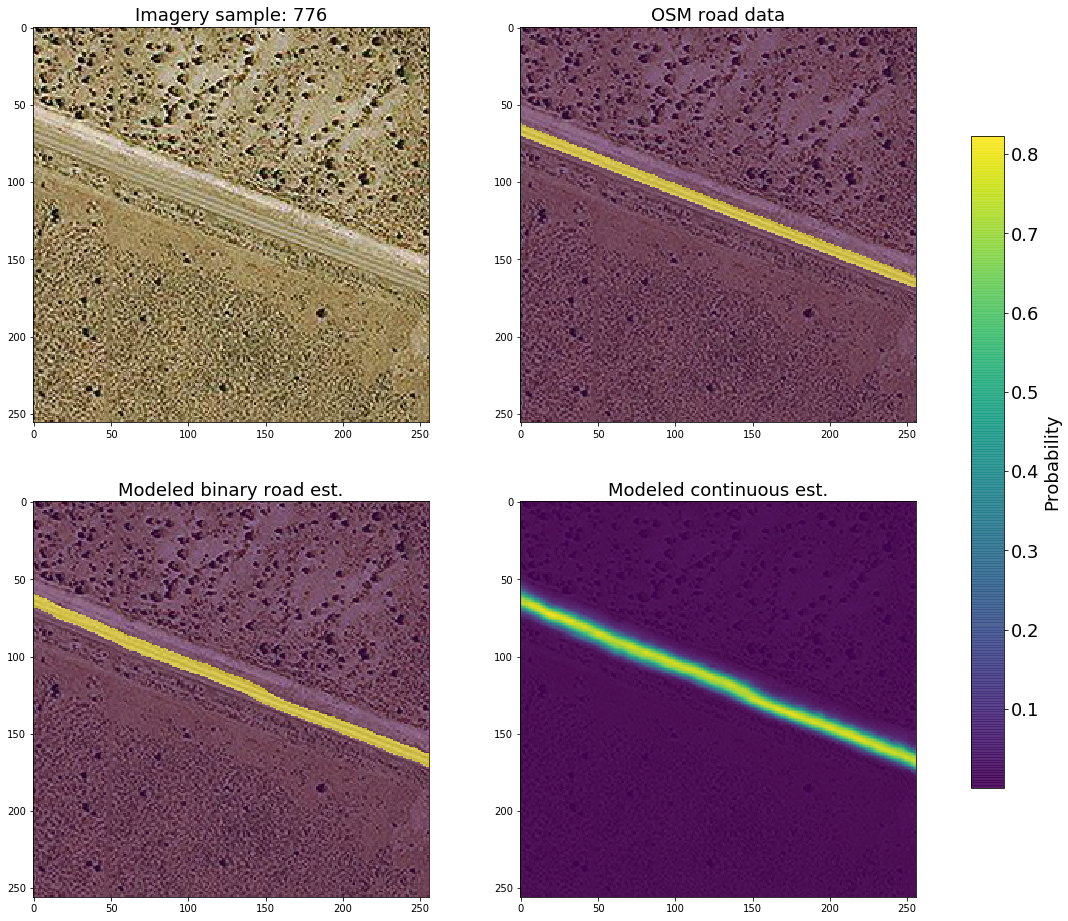

In [32]:
f, ax = plt.subplots(2,2, figsize=(20, 16))
sample = np.random.randint(0, len(x_val))
sample = 776
x_ = x_val[sample].astype('float32')
y_ = y_val[sample]
ax[0,0].imshow(x_)
ax[0,0].set_title('Imagery sample: %s'%sample,fontsize=18)
ax[0,1].imshow(x_)
ax[0,1].imshow(y_, alpha=0.5)
ax[0,1].set_title('OSM road data',fontsize=18)
ax[1,0].imshow(x_)
#binary classify the road surface

ax[1,0].imshow(x_)
ax[1,0].imshow(y_hat[sample], alpha=0.5)
ax[1,0].set_title('Modeled binary road est.',fontsize=18)

ax[1,1].imshow(x_)
im = ax[1,1].imshow(y_pr[sample][:,:,0], alpha=0.9)
ax[1,1].set_title('Modeled continuous est.',fontsize=18)
cb = f.colorbar(im, ax=ax.ravel().tolist(),shrink=0.75)
cb.ax.tick_params(labelsize=18)
cb.set_label('Probability', fontsize=18)
#f.savefig('./figures/example_quad_%s.png'%(sample), dpi=600, bbox_inches='tight')

Normalized confusion matrix
[[ 0.99576539  0.00423461]
 [ 0.22909253  0.77090747]]


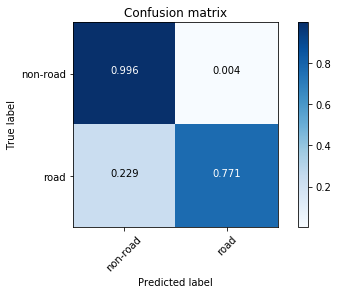

In [33]:
cnf_matrix = confusion_matrix(y_hat[sample].flatten(), \
                              y_val[sample].flatten())
plot_confusion_matrix(cnf_matrix, classes=['non-road', 'road'], title='Confusion matrix', normalize=True)
plt.savefig('./figures/val_confusion_matrix_sample_%s.png'%(sample)\
            , dpi=400, bbox_inches='tight')

In [41]:
divs = 100

precision = np.zeros(divs) 
recall = np.zeros(divs) 
f1 = np.zeros(divs) 
thr = np.linspace(0,1,divs)
for i in range(divs):
    mask = np.zeros(y_pr.shape[:3])
    mask[y_pr[:,:,:,0]>=thr[i]] = 1
    _, precision[i], recall[i], f1[i] = segtools.accuracy_summaries(y_val, mask)

# Results of Recall and Precision analysis on the entire validation dataset

As we move left to right along the RP curve, we will decrease our threshold for binary classification of road and non-road. We can increase recall with a lowered threshold, but right over predicting road areas, where there really are not any. The F1-score is the harmonic mean of the recall and precision (sort of like the mean, but for rates). We maximize the F1-score at 

Optimized levels: 
 Threshold: 0.35 
 Recall: 0.66 
 Precision: 0.59 
 F1-Score: 0.62


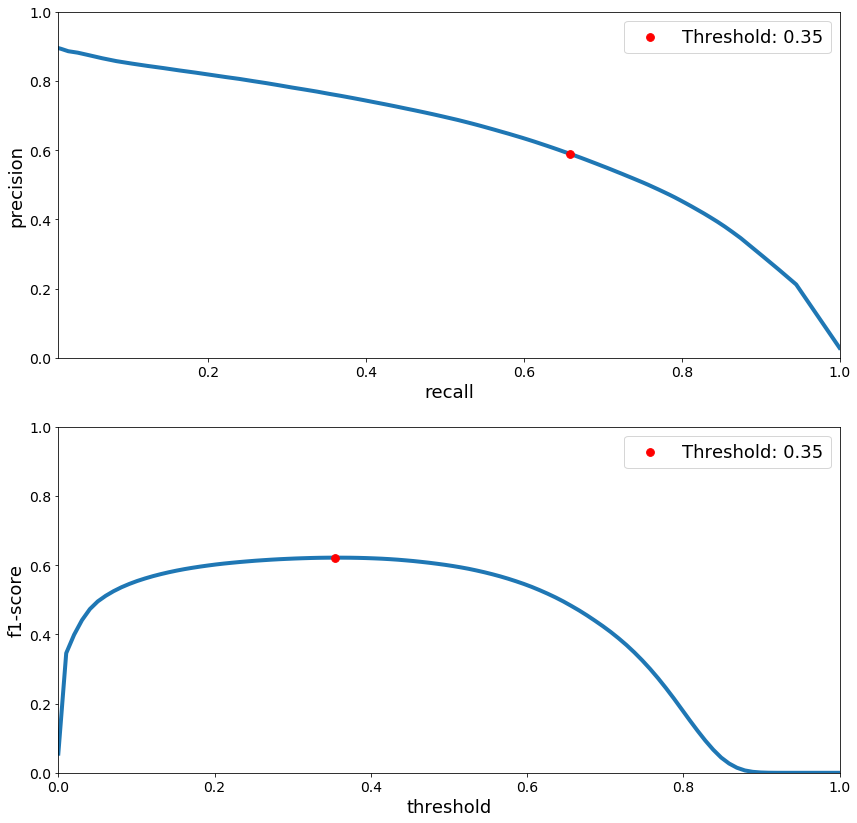

In [50]:
f, ax = plt.subplots(2,1,figsize=(14,14))
ax[0].plot(recall,precision, lw=4, zorder=1)
ax[0].scatter(recall[np.argmax(f1)], precision[np.argmax(f1)], color='red', s=60, zorder=2,\
              label='Threshold: %.2f'%thr[np.argmax(f1)])
ax[0].set_xlim(0.01,1)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('recall', fontsize=18)
ax[0].set_ylabel('precision',fontsize=18)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].legend(fontsize=18)
ax[1].plot(thr, f1, lw=4, zorder=1)
ax[1].scatter(thr[np.argmax(f1)], f1[np.argmax(f1)], color='red', s=60, zorder=2, \
              label='Threshold: %.2f'%thr[np.argmax(f1)])
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1)
ax[1].set_ylabel('f1-score', fontsize=18)
ax[1].set_xlabel('threshold',fontsize=18)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)
ax[1].legend(fontsize=18)
print('Optimized levels: \n Threshold: %.2f \n Recall: %.2f \n Precision: %.2f \n F1-Score: %.2f'%(thr[np.argmax(f1)],\
                                           recall[np.argmax(f1)],\
                                           precision[np.argmax(f1)],\
                                          f1[np.argmax(f1)]))
#f.savefig('./figures/prec_recall.png', dpi=400, bbox_inches='tight')

precision: 0.77090747331, 
 recall: 0.866066966517, 
 f1-score: 0.815721346199


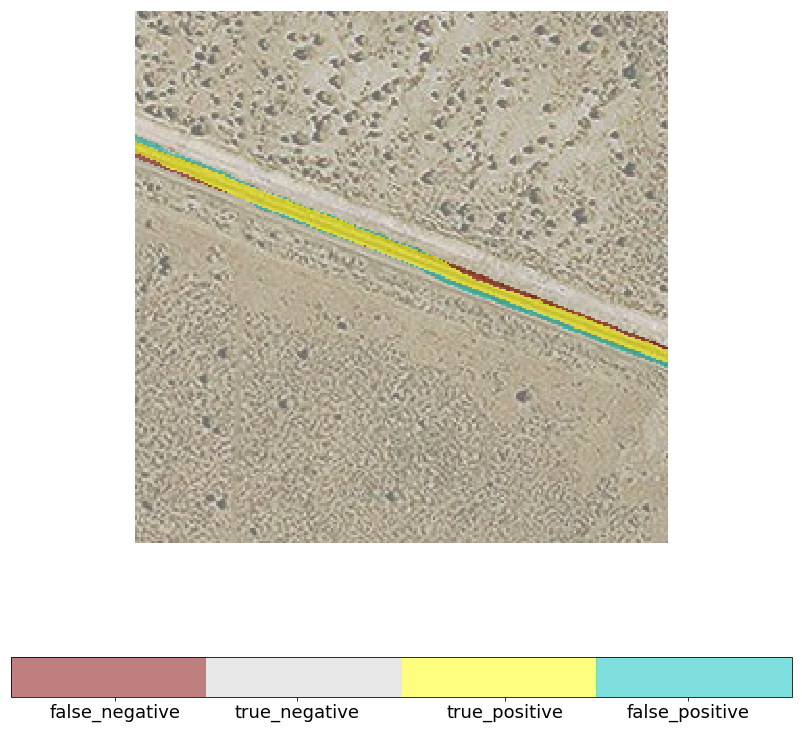

In [36]:
#N = 4

mac, precision, recall, f1 = segtools.accuracy_summaries(y_val[sample], y_hat[sample])
print('precision: %s, \n recall: %s, \n f1-score: %s'%(precision, recall, f1))
#print('precision: %s, \n recall: %s, \n f1-score: %s'%(precision2, recall2, f1))
f, ax = plt.subplots(1,1,figsize=(14,14))
ax.set_axis_off()
cmap = mpl.colors.ListedColormap(['maroon','lightgrey','yellow','c'])
ax.imshow(x_)
#ax[1].imshow(x_)
im = ax.imshow(mac, cmap=cmap, alpha=0.5)
#im2 = ax[1].imshow(mac2, cmap=cmap, alpha=0.5)
bounds = [0.4, 1.1, 1.9, 2.6]
labels = ['false_negative', 'true_negative', 'true_positive', 'false_positive']
cb = f.colorbar(im, orientation='horizontal')
cb.set_ticks(bounds)
cb.set_ticklabels(labels)
cb.ax.tick_params(labelsize=18)
#f.savefig('./figures/example_acc_out_sample_%s.png'%(sample), dpi=600, bbox_inches='tight')

## If we didn't care about false positives, and just wanted the highest recall possible, we could just reduce our threshold to a low level.. 

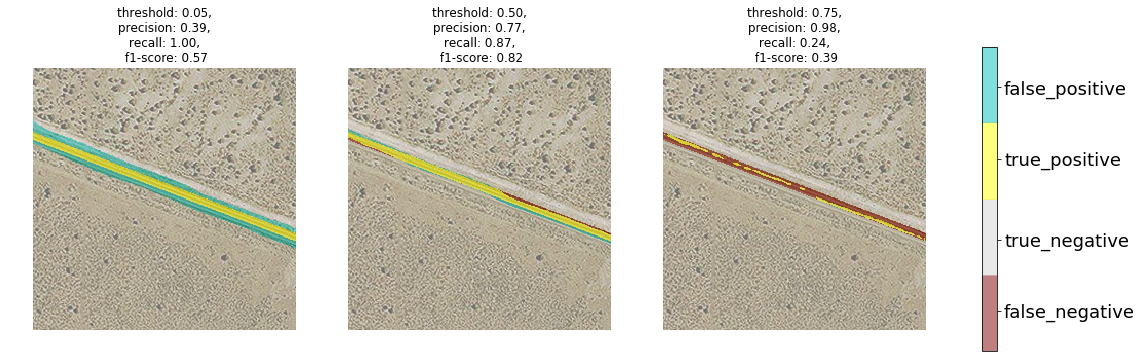

In [117]:
#use a modified y_hat...
thr = [0.05,0.5,0.75]
f, ax = plt.subplots(1,len(thr),figsize=(20,14))
for t in range(len(thr)):
    y_hat_mod = np.zeros((pr.shape[0], pr.shape[1]))
    y_hat_mod[pr[:,:,1]<=(1-thr[t])]=1
    y_hat_mod = y_hat_mod.reshape((pr.shape[0], 256, 256))
    mac, precision, recall, f1 = segtools.accuracy_summaries(y_val[sample], y_hat_mod[sample])
    ax[t].set_title('threshold: %.2f,\n precision: %.2f, \n recall: %.2f, \n f1-score: %.2f'
                    %(thr[t], precision, recall, f1))
    ax[t].set_axis_off()
    cmap = mpl.colors.ListedColormap(['maroon','lightgrey','yellow','c'])
    ax[t].imshow(x_)
    im = ax[t].imshow(mac, cmap=cmap, alpha=0.5, vmin=0, vmax=3)
bounds = [0.4, 1.1, 1.9, 2.6]
labels = ['false_negative', 'true_negative', 'true_positive', 'false_positive']
cb = f.colorbar(im, ax=ax.ravel().tolist(),shrink=0.4)
cb.set_ticks(bounds)
cb.set_ticklabels(labels)
cb.ax.tick_params(labelsize=18)
f.savefig('./figures/example_thresholding_out_sample_%s.png'%(sample), dpi=600, bbox_inches='tight')

# Confusion Matrix for the entire validation set

In [37]:
cnf_matrix = confusion_matrix(y_hat.flatten(), y_val.flatten())

Normalized confusion matrix
[[ 0.98657744  0.01342256]
 [ 0.32692984  0.67307016]]


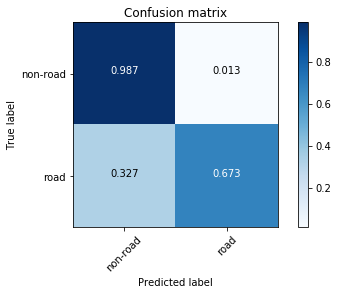

In [38]:
plot_confusion_matrix(cnf_matrix, classes=['non-road', 'road'], title='Confusion matrix', normalize=True)
#plt.savefig('./figures/val_confusion_matrix.png', dpi=600, bbox_inches='tight')

In [12]:
# data type is wrong in validation
# get validation data to check things out
test_batch = len(glob('./images/test/a/*.png'))
test_generator = segtools.data_generator('/contents/images/test', batch_size=test_batch)
x_test, y_test = next(test_generator)
n_classes = 2
y_test, _ = segtools.post_process_y(y_test, n_classes)
pr_test = model.predict(x_test)
y_hat_test, y_pr_test = segtools.post_process_y(pr_test, n_classes)
cnf_matrix = confusion_matrix(y_hat_test.flatten(), y_test.flatten())

In [22]:
samples = np.array([[136,107],[218, 101],[177,255]])
#samples = np.random.choice(np.arange(500),4).reshape((2,2))

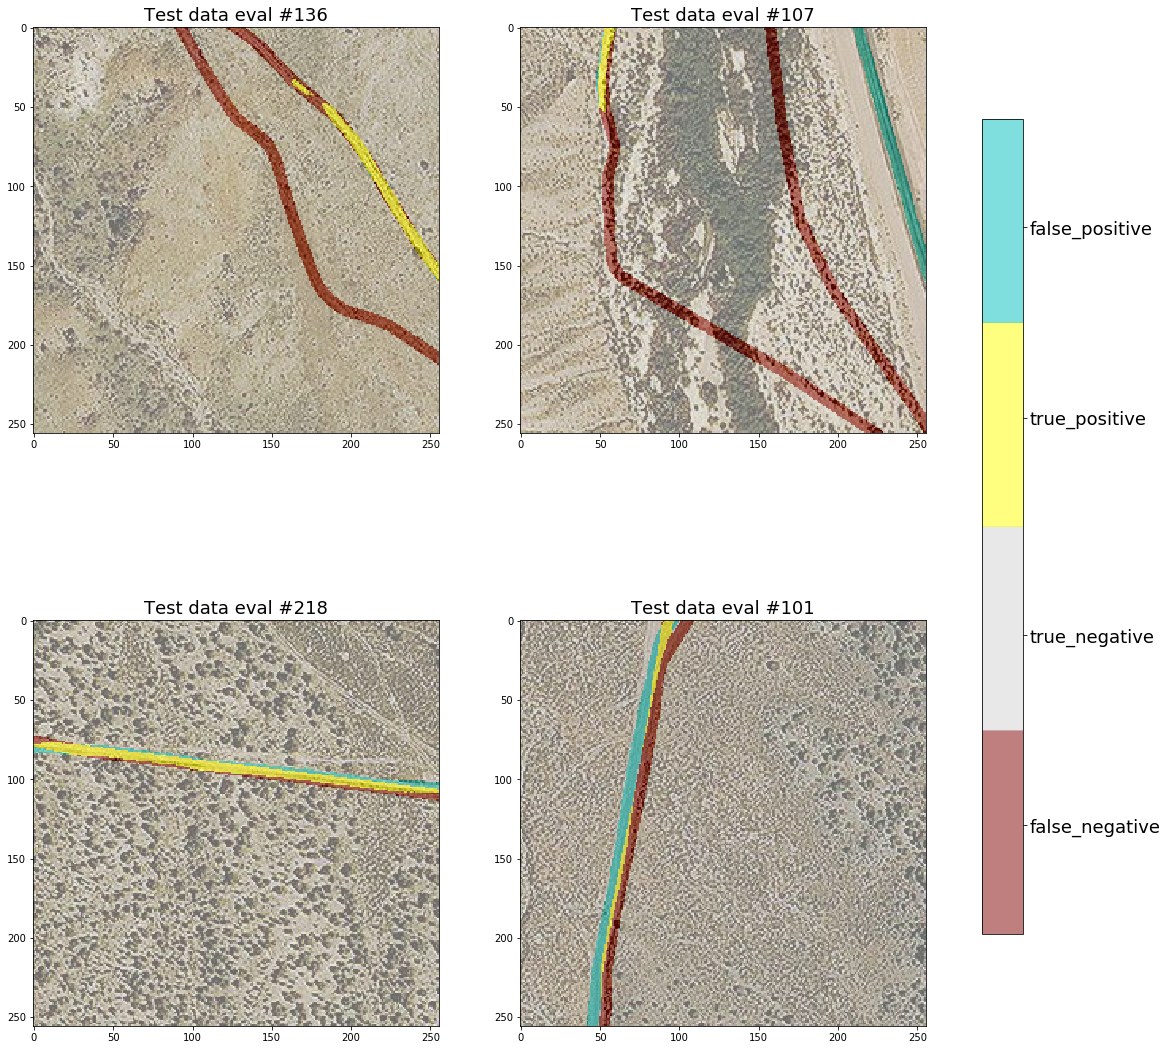

In [23]:
r, c = (2,2)
f, ax = plt.subplots(r,c, figsize=(20,20))
cmap = mpl.colors.ListedColormap(['maroon','lightgrey','yellow','c'])
for i in range(r):
    for j in range(c):
        mac, precision, recall, f1 = segtools.accuracy_summaries(y_test[samples[i,j]], \
                                                                 y_hat_test[samples[i,j]])
        ax[i,j].imshow(x_test[samples[i,j]].astype('float32'))
        im = ax[i,j].imshow(mac, cmap=cmap, alpha=0.5)
        ax[i,j].set_title('Test data eval #%s'%samples[i,j], fontsize=18)
bounds = [0.4, 1.1, 1.9, 2.6]
labels = ['false_negative', 'true_negative', 'true_positive', 'false_positive']
cb = f.colorbar(im, ax=ax.ravel().tolist(),shrink=0.75)
cb.set_ticks(bounds)
cb.set_ticklabels(labels)
cb.ax.tick_params(labelsize=18)
#f.savefig('./figures/test_eval_quad_1.png', dpi=300, bbox_inches='tight')

Normalized confusion matrix
[[ 0.98551529  0.01448471]
 [ 0.47661134  0.52338866]]


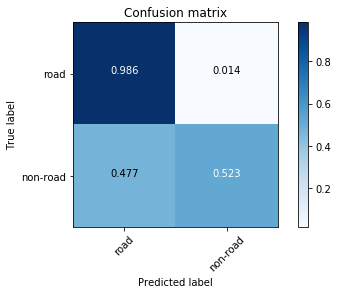

In [51]:
plot_confusion_matrix(cnf_matrix, classes=['road', 'non-road'], title='Confusion matrix', normalize=True)
#plt.savefig('./figures/test_confusion_matrix.png', dpi=600, bbox_inches='tight')